In [3]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import pandas as pd
import numpy as np
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import sklearn
from itertools import permutations
from pprint import pprint
from PIL import Image
import PIL
import pyodbc
from tqdm import tqdm
from random import random
from random import randrange
import math
import seaborn as sns
from matplotlib.lines import Line2D
from torchsummary import summary


In [4]:
plt.ion()   # interactive mode
testimages = list()
testclasses = list()
testindices = list()
testinitialized = 0
PATH = './test_net3.tar'
ndepth = 4
nminibatchsize = 4
classes = ('Hospitalized','Intubated','Deceased','Pneumonia')
columns = ['Male','Pregnant','Diabetes','Asthma','Immunocompromised'
            ,'Hypertension','Other Disease','Cardiovascular Disease','Obesity','Kidney Disease'
            ,'Tobacco Use','COPD']
nclasses = len(classes)
ncolumns = len(columns)
testratio = 0.2 #randomly select this proportion of the dataset to be test data

In [5]:
nfeatures = 1.0
for i in range(ndepth-1):
    nfeatures *= (ncolumns - i)
nimgsize = math.ceil(nfeatures**0.5)
npix = nimgsize**2
normtuple = list()
for i in range(ndepth): normtuple.extend([0.5])
normtuple = tuple(normtuple)

print('total features: %i; image size: %i x %i x %i' % (nfeatures,nimgsize,nimgsize,ndepth))
print('image normalization tuple:')
print(normtuple)

total features: 1320; image size: 37 x 37 x 4
image normalization tuple:
(0.5, 0.5, 0.5, 0.5)


In [39]:
def getlabelval(labeldata):
    retval = np.array(list(labeldata),dtype=np.float32)
    return retval

def createimagetensor(row=None):
    if row:
        icol = 0
        irow = 0
        if len(list(row[0])) != ncolumns: raise CustomError('Invalid Input Size: Expected %i, Received %i' % (ncolumns,len(list(row[0]))))
        if len(row) < 2: raise CustomError('Invalid Data: Expected row format is [bindata,age,labels(optional)]')
        imgdata = np.zeros((nimgsize,nimgsize,ndepth),dtype=np.float32)
        for px in permutations(list(row[0]),ndepth-1):
            thispx = list()
            for chan in px: thispx.extend([float(chan)])
            thispx.extend([float(row[1])/100.])
            imgdata[icol,irow,:] = thispx
            irow += 1
            if (irow > nimgsize - 1):
                icol += 1
                irow = 0
        return TF.normalize(TF.to_tensor(imgdata),normtuple,normtuple)
    else:
        return None

class CustomError(Exception):
    pass


In [42]:
#create generator function for data acquisition and conversion to torch image format.
#function must return a tuple of form (tensor containing 4 images,tensor containing 4 labels)
#also builds a test set using a quick and dirty random number method.  this will need to be 
#improved to balance both the test and train sets across potential labels.

def nextrow():
    conn = pyodbc.connect('DSN=covid;UID=seh;PWD=Welcome2020!;')
    crsr = conn.cursor()
    crsr.execute("{CALL getpydatav2}")
    rowcnt = 0
    imgs = list()
    labels = list()
    row = [0,1,2]
    idx = 0
    while row:
        while (rowcnt<nminibatchsize):
            try:
                row = crsr.fetchone()
            except:
                conn = pyodbc.connect('DSN=covid;UID=seh;PWD=Welcome2020!;')
                crsr = conn.cursor()
                crsr.execute("{CALL getpydatav2}")
                crsr.skip(idx*nminibatchsize + rowcnt)
                row = crsr.fetchone()
            rowcnt += 1
            if row:
                imgtensor = createimagetensor(row)
                labels.append(getlabelval(row[2]))
                imgs.append(imgtensor)
            else:
                break
        if row:
            if (testinitialized == 0):
                if (random() < testratio):
                    testimages.append(torch.stack(imgs))
                    testclasses.append(torch.tensor(labels))
                    testindices.append(idx)
                else:
                    yield torch.stack(imgs),torch.tensor(labels)
            elif (idx not in testindices):
                yield torch.stack(imgs),torch.tensor(labels)
            rowcnt = 0
            idx += 1
            imgs = list()
            labels = list()
        else:
            break


In [152]:
#create generator function for test set
def gentestdata(startindex = 0):
    for i,clss in enumerate(testclasses[startindex:],startindex):
        yield testimages[i],clss

def gettestdata(idx = 0):
    return testimages[idx],testclasses[idx]

def createfakedata(age=None, conds=None):
    if age is None: age = randrange(15,90)
    elif isinstance(age,tuple): age = randrange(age[0],age[1])
    bindata = ''
    if isinstance(conds,list):
        for col in columns:
            bindata += ('1' if col in conds else '0') 
        return createimagetensor([bindata,age]).unsqueeze(0)
    elif isinstance(conds,str):
        for col in columns:
            bindata += ('1' if col in conds else '0') 
        return createimagetensor([bindata,age]).unsqueeze(0)
    totconds = (conds if isinstance(conds,int) and conds < ncolumns else math.floor(ncolumns*random()))
    condsapplied = 0
    for i,col in enumerate(columns):
        if condsapplied < totconds:
            if random() >= 0.5:
                if i == 1 and (age > 55 or bindata[0] == '1'):
                    bindata += '0'
                else:
                    bindata += '1'
                    condsapplied += 1
            else:
                bindata += '0'
        else:
            bindata += '0'
    return createimagetensor([bindata,age]).unsqueeze(0)

In [12]:
#the net below is built from the CIFAR tutorial in pytorch
#needs major changes to function correctly in this application
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
       
        # 3 input image channels, 6 output channels, 5x5 square convolution
        self.conv1 = nn.Conv2d(ndepth, ncolumns, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(ncolumns, ncolumns*4, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(9408, 578)  
        self.fc2 = nn.Linear(578, 34)
        self.fc3 = nn.Linear(34, nclasses) 

    def forward(self, x):
        x = F.relu(self.conv1(x))
        #print(x.size())
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.size())
        x = x.view(-1, 9408)
        #print(x.size())
        x = F.relu(self.fc1(x))
        #print(x.size())
        x = F.relu(self.fc2(x))
        #print(x.size())
        x = self.fc3(x)
        #print(x.size())
        return F.sigmoid(x)

net = Net()

#loss function and optimizer were set based on CIFAR example also
#need to experiment with different hyperparameters and types
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)
print((ndepth,nimgsize,nimgsize))
print(summary(net,(ndepth,nimgsize,nimgsize)))

(4, 37, 37)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 33, 33]           1,212
            Conv2d-2           [-1, 48, 29, 29]          14,448
         MaxPool2d-3           [-1, 48, 14, 14]               0
            Linear-4                  [-1, 578]       5,438,402
            Linear-5                   [-1, 34]          19,686
            Linear-6                    [-1, 4]             140
Total params: 5,473,888
Trainable params: 5,473,888
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.48
Params size (MB): 20.88
Estimated Total Size (MB): 21.39
----------------------------------------------------------------
None


In [13]:
#train a new model
validationfreq = 1000

for epoch in range(2):  # loop over the dataset multiple times
    lasttestidx = 0
    running_loss = 0.0
    testcnt = 0
    rowgen = nextrow()
    pbar = tqdm(enumerate(rowgen),total=6798)
    for i, data in pbar:
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        #print((outputs,labels))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % validationfreq == validationfreq - 1:    # print every 100 mini-batches
            #tqdm.write('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 200))
            valid_loss = 0.0
            net.eval()
            with torch.no_grad():
                randomstartindex = math.floor(len(testimages)*random())
                genfunc = gentestdata(randomstartindex)
                for j, (tin,tlab) in enumerate(genfunc):
                    lasttestidx = j + 1
                    outputs = net(tin)
                    loss = criterion(outputs,tlab)
                    valid_loss += loss.item()
                    if j >= 20: break
            pbar.set_description(desc='[%d, %5d] loss: %.3f; validation loss: %.3f; validation count: %i; test start index: %i' 
                                        % (epoch + 1, i + 1, running_loss / validationfreq,valid_loss / lasttestidx,lasttestidx,randomstartindex))
            running_loss = 0.0
            net.train()
        pbar.update()
    testinitialized = 1
net.eval()
#save test set and model state dictionary for loading later without training.
torch.save({'model_state_dict':net.state_dict(),
            'testimages': testimages,
            'testclasses': testclasses,
            'testindices': testindices}, PATH)
print('Finished Training')

[1,  6000] loss: 0.446; validation loss: 0.471; validation count: 21; test start index: 923:  99%|█████████▉| 6764/6798 [29:13<00:08,  3.86it/s]
[2,  6000] loss: 0.441; validation loss: 0.440; validation count: 21; test start index: 1526:  99%|█████████▉| 6764/6798 [33:25<00:10,  3.37it/s]
Finished Training


In [20]:
def interpretimagetensor(imgtensor):
    ptsdata = list()
    for (bindata,age) in getbindatafromimagetensor(imgtensor):
        ptdata = str(int(age)) + ' yo, '
        for i, val in enumerate(list(bindata)):
            if i == 0:
                if val == '1':
                    ptdata += 'Male, '
                else:
                    ptdata += 'Female, '
            elif val == '1':
                ptdata += columns[i] + ', '
        ptdata = ptdata[:-2]
        ptsdata.append(ptdata)
    return ptsdata

def getbindatafromimagetensor(imgtensor):
    ptsdata = list()
    for case in imgtensor:
        case = case / 2 + 0.5
        case = case.numpy()
        case = np.transpose(case, (1, 2, 0))
        bindata = ''
        for i in range(ndepth-1): bindata += str(int(case[0,0,i]))
        for i in range(1,ncolumns - ndepth + 2):
            bindata += str(int(case[0,i,ndepth-2]))
        age = float(round(float(case[0,0,ndepth-1])*100.))
        ptsdata.append((bindata, age))
    return ptsdata


In [9]:
#skip training and load saved model
checkpoint = torch.load(PATH)
net = Net()
net.load_state_dict(checkpoint['model_state_dict'])
testimages = checkpoint['testimages']
testclasses = checkpoint['testclasses']
testindices = checkpoint['testindices']
testinitialized = 1
net.eval()

Net(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3468, out_features=578, bias=True)
  (fc2): Linear(in_features=578, out_features=34, bias=True)
  (fc3): Linear(in_features=34, out_features=4, bias=True)
)

In [37]:
#test random image from test set
net.eval()
randomstartindex = math.floor(len(testimages)*random())
print(randomstartindex)
images, labels = gettestdata(randomstartindex)

with torch.no_grad():
    outputs = net(images)
    ptinfo = interpretimagetensor(images)
    for i in range(nminibatchsize):
        actlist = list()
        predlist = list()
        if sum(labels[i]) == 0.:
            actlist.append('none')
        for j in range(nclasses):
            predlist.extend([str(round(100*float(outputs[i,j]),2)) + '% ' + classes[j]])
            if labels[i,j] == 1.: actlist.extend([classes[j]])
        print(ptinfo[i])
        print(predlist)
        print(actlist)
        print()

1492
69 yo, Male
['64.87% Hospitalized', '13.04% Intubated', '32.68% Deceased', '52.0% Pneumonia']
['Hospitalized', 'Deceased', 'Pneumonia']

48 yo, Female, Diabetes
['43.58% Hospitalized', '7.27% Intubated', '13.96% Deceased', '34.5% Pneumonia']
['Hospitalized', 'Pneumonia']

49 yo, Male, Diabetes, Hypertension, Obesity
['66.8% Hospitalized', '14.45% Intubated', '36.32% Deceased', '55.03% Pneumonia']
['Hospitalized', 'Pneumonia']

52 yo, Male
['43.59% Hospitalized', '7.03% Intubated', '14.1% Deceased', '34.81% Pneumonia']
['none']



In [153]:
fakedata = createfakedata(age=(51,61),conds=['Male','Diabetes','Hypertension'])
outputs = net(fakedata)
print(interpretimagetensor(fakedata))
predlist = list()
for i in range(nclasses):
    predlist.extend([str(round(100*float(outputs[0,i]),2)) + '% ' + classes[i]])
print(predlist)


['51 yo, Male, Diabetes, Hypertension']
['65.24% Hospitalized', '12.08% Intubated', '31.05% Deceased', '51.76% Pneumonia']


In [ ]:
#model results by class
class_correct = list(0. for i in range(6))
class_total = list(0. for i in range(6))
with torch.no_grad():
    genfunc = gentestdata(0)
    for data in genfunc:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(6):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

In [22]:
labelstats = dict()
for c in classes:
    labelstats[c] = {
        "predprobs" : list(),
        "age" : list(),
        "sex" : list(),
        "conditions" : list()
    }

with torch.no_grad():
    genfunc = gentestdata(0)
    for j, (images,labels) in tqdm(enumerate(genfunc,0),total=len(testimages)):
        outputs = net(images)
        outcomes = np.array(outputs)
        ptinfo = interpretimagetensor(images)
        for i, case in enumerate(outcomes):
            for k, lab in enumerate(labels[i]):
                if lab == 1:
                    thisdict = labelstats[classes[k]]
                    thisdict['predprobs'].append(list(case))
                    thisinfo = ptinfo[i].split(', ')
                    thisdict['age'].append(int(thisinfo[0].strip(' yo')))
                    thisdict['sex'].append(thisinfo[1])
                    thisdict['conditions'].append(thisinfo[2:])



100%|██████████| 1733/1733 [00:38<00:00, 45.26it/s]


In [23]:
flatlblstats = {
    "truth" : list(),
    "predprobs" : list(),
    "age" : list(),
    "conditions" : list()
    }

with torch.no_grad():
    genfunc = gentestdata(0)
    for j, (images,labels) in tqdm(enumerate(genfunc,0),total=len(testimages)):
        outputs = net(images)
        outcomes = np.array(outputs)
        ptinfo = interpretimagetensor(images)
        for i, case in enumerate(outcomes):
            flatlblstats['truth'].append([classes[j] for (j,lab) in enumerate(labels[i]) if lab == 1])
            flatlblstats['predprobs'].append(list(case))
            thisinfo = ptinfo[i].split(', ')
            flatlblstats['age'].append(int(thisinfo[0].strip(' yo')))
            if thisinfo[1] == 'Male':
                flatlblstats['conditions'].append(thisinfo[1:])
            else:
                flatlblstats['conditions'].append(thisinfo[2:])



100%|██████████| 1733/1733 [00:37<00:00, 46.68it/s]


In [24]:
predsbyage = {
    'age': list(),
    }
actualbyage = {
    'age': list(),
    }
for c in classes:
    predsbyage[c] = list()
    actualbyage[c] = list()

for i in tqdm(range(100)):
    predsums = np.zeros(nclasses,dtype=np.float32)
    actsums = np.zeros(nclasses,dtype=np.float32)
    #actsums *= 10
    for j,ag in enumerate(flatlblstats['age']):
        if ag == i:
            for k, val in enumerate(flatlblstats['predprobs'][j]):
                predsums[k] += val
            for k, val in enumerate(flatlblstats['truth'][j]):
                actsums[classes.index(val)] += 1
    predsbyage['age'].append(i)
    actualbyage['age'].append(i)
    for j, c in enumerate(classes):
        predsbyage[c].append(predsums[j])
        actualbyage[c].append(actsums[j])



100%|██████████| 100/100 [00:00<00:00, 434.07it/s]


In [26]:
agedistfromactual = dict()
agedistfrompreds = dict()
for c in classes:
    agedistfromactual[c] = list()
    agedistfrompreds[c] = list()
    for i,val in enumerate(actualbyage[c]):
        agedistfromactual[c].extend([i]*int(val))
    for i,val in enumerate(predsbyage[c]):
        agedistfrompreds[c].extend([i]*int(round(val)))


In [27]:
agedf = pd.DataFrame(columns=['age','type','result'])
#agedf.loc[0] = pd.Series({'age':0,'type':'Predicted','result':'Deceased'})
runi = 0
for c in classes:
    print('Begin predicted ' + c + ' - %i total records' % (runi))
    for i,val in enumerate(agedistfrompreds[c]):
        agedf.loc[i+runi] = pd.Series({'age':float(val),'type':'Predicted','result':c})
    runi += (i + 1)
    print('Begin actual ' + c + ' - %i total records' % (runi))
    for i,val in enumerate(agedistfromactual[c]):
        agedf.loc[i+runi] = pd.Series({'age':float(val),'type':'Actual','result':c})
    runi += (i + 1)

print('Complete - %i total records' % (runi))

Begin predicted Hospitalized - 0 total records
Begin actual Hospitalized - 2757 total records
Begin predicted Intubated - 5588 total records
Begin actual Intubated - 6161 total records
Begin predicted Deceased - 6632 total records
Begin actual Deceased - 7785 total records
Begin predicted Pneumonia - 8893 total records
Begin actual Pneumonia - 11179 total records
Complete - 13469 total records


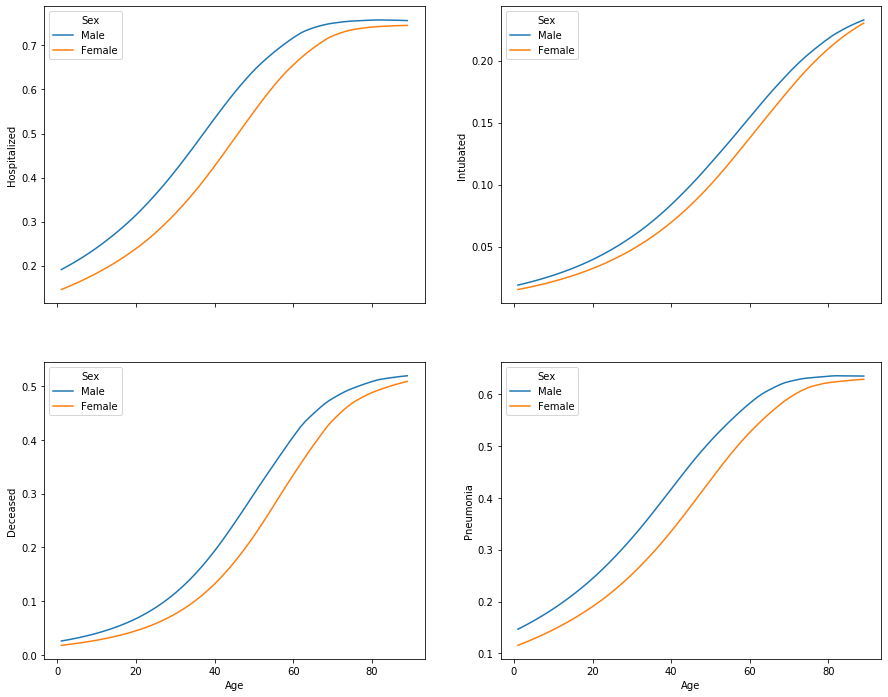

In [186]:
agesexconddf = pd.DataFrame(columns=['Age','Sex','Condition','Hospitalized','Intubated','Deceased','Pneumonia'])
condlist1 = []
condlist2 = ['Diabetes','Hypertension']
conds1 = list()
conds2 = list()
for c in condlist1:
    conds1.append(c)
if len(conds1) == 0: conds1.append('None')
for c in condlist2:
    conds2.append(c)
if len(conds2) == 0: conds2.append('None')
mconds1 = conds1.copy()
mconds1.append('Male')
mconds2 = conds2.copy()
mconds2.append('Male')
miage = 1
maage = 90
with torch.no_grad():
    for a in range(miage,maage+1):
        mdata = np.array(net(createfakedata(age=a,conds=mconds1)))[0]
        fdata = np.array(net(createfakedata(age=a,conds=conds1)))[0]
        mdata2 = np.array(net(createfakedata(age=a,conds=mconds2)))[0]
        fdata2 = np.array(net(createfakedata(age=a,conds=conds2)))[0]
        nocondagedist.loc[a-1] = pd.Series({'Age':float(a/2),'Sex':'Male','Hospitalized':mdata[0],'Intubated':mdata[1],'Deceased':mdata[2],'Pneumonia':mdata[3]})
        nocondagedist.loc[a] = pd.Series({'Age':float(a/2),'Sex':'Female','Hospitalized':fdata[0],'Intubated':fdata[1],'Deceased':fdata[2],'Pneumonia':fdata[3]})

fig, axs = plt.subplots(2,2,figsize=(15,12),sharex=True,sharey=False)
i = 0
for k, axi in enumerate(axs):
    for j in range(2):
        axe = axi[j]
        sns.lineplot(ax=axe, x='Age', y=classes[i], hue='Condition', style='Sex', data=nocondagedist)
        i += 1


Text(0.5, 1.0, 'Actual vs. Predicted Age Distribution by Outcome')

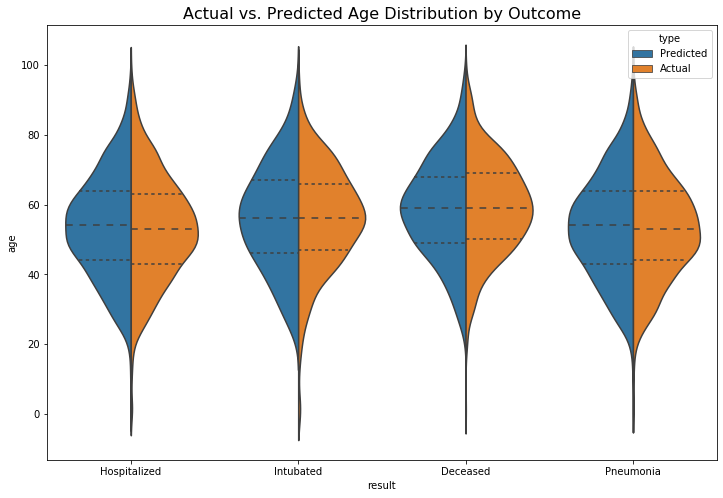

In [28]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax = sns.violinplot(x='result',y='age',hue='type',data=agedf,split=True,inner='quartile')
ax.set_title('Actual vs. Predicted Age Distribution by Outcome',fontsize=16)


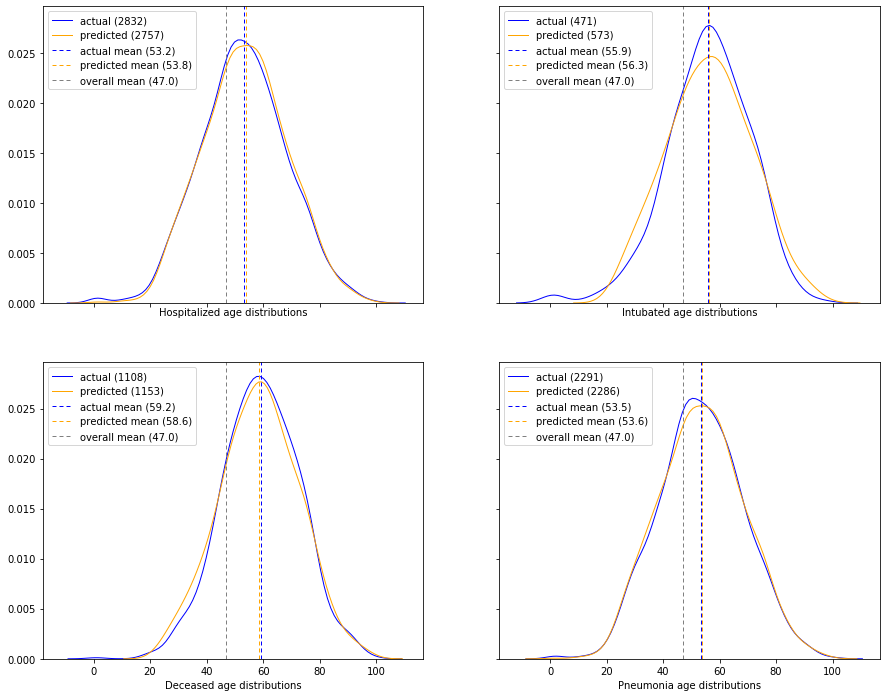

In [177]:
fix, axs = plt.subplots(2,2,figsize=(15,12),sharex=True,sharey=True)
custom_lines = [Line2D([0], [0], color='blue', lw=1),
                Line2D([0], [0], color='orange', lw=1),
                Line2D([0], [0], color='blue', lw=1, dashes=(4.,3.)),
                Line2D([0], [0], color='orange', lw=1, dashes=(4.,3.)),
                Line2D([0], [0], color='grey', lw=1, dashes=(4.,3.))]
i = 0
for k, axi in enumerate(axs):
    for j in range(2):
        axe = axi[j]
        sns.distplot(labelstats[classes[i]]['age'], hist = False, kde = True,kde_kws = {'linewidth': 1}
                        ,ax=axe,axlabel=classes[i]+' age distributions',color='blue')
        sns.distplot(agedistfrompreds[classes[i]], hist = False, kde = True,kde_kws = {'linewidth': 1}
                        ,ax=axe,color='orange')
        axe.axvline(x=round(np.mean(flatlblstats['age']),1),color='grey',dashes=(4.,3.),lw=1)
        axe.axvline(x=round(np.mean(labelstats[classes[i]]['age']),1),color='blue',dashes=(4.,3.),lw=1)
        axe.axvline(x=round(np.mean(agedistfrompreds[classes[i]]),1),color='orange',dashes=(4.,3.),lw=1)
        axe.legend(custom_lines,('actual ('+str(len(labelstats[classes[i]]['age']))+')','predicted ('+str(len(agedistfrompreds[classes[i]]))+')'
                                                        ,'actual mean ('+str(round(np.mean(labelstats[classes[i]]['age']),1))+')'
                                                        ,'predicted mean ('+str(round(np.mean(agedistfrompreds[classes[i]]),1))+')'
                                                        ,'overall mean ('+str(round(np.mean(flatlblstats['age']),1))+')'))
        i += 1

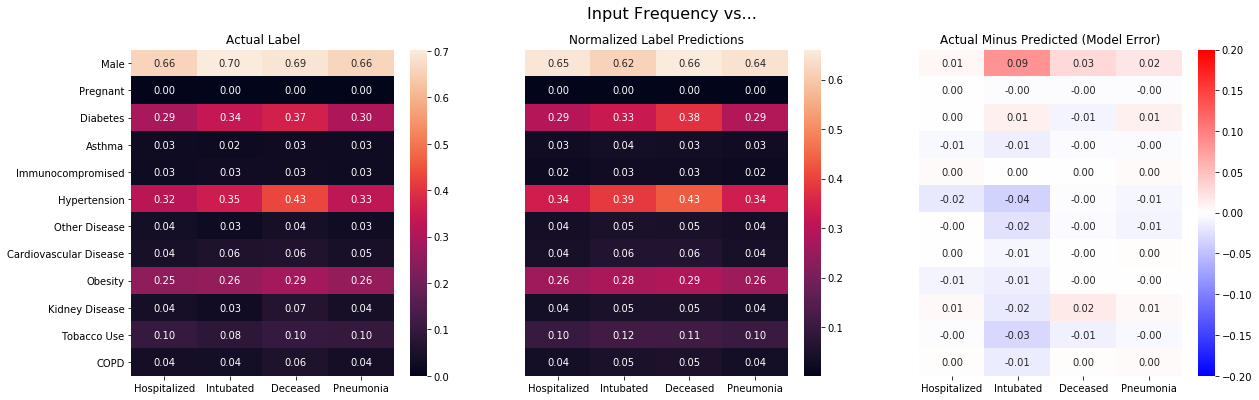

In [30]:
truthcondheatmap = np.zeros((nclasses,ncolumns),dtype=np.float32)
predcondheatmap = np.zeros((ncolumns,nclasses),dtype=np.float32)
for i,trth in enumerate(flatlblstats['truth']):
    for cond in flatlblstats['conditions'][i]:
        for lab in trth:
            truthcondheatmap[classes.index(lab),columns.index(cond)] += 1
        predcondheatmap[columns.index(cond)] += flatlblstats['predprobs'][i]
predcondheatmap = predcondheatmap.T
for i in range(nclasses):
    truthcondheatmap[i] /= len(labelstats[classes[i]]['age'])
    predcondheatmap[i] /= sum(predsbyage[classes[i]])
fig, axs = plt.subplots(1,3,figsize=(20,6))
sns.heatmap(truthcondheatmap.T,ax=axs[0],yticklabels=columns,xticklabels=classes,annot=True,fmt='.2f')
sns.heatmap(predcondheatmap.T,ax=axs[1],yticklabels=False,xticklabels=classes,annot=True,fmt='.2f')
sns.heatmap((truthcondheatmap - predcondheatmap).T,ax=axs[2],yticklabels=False,xticklabels=classes,annot=True,fmt='.2f',cmap='bwr',vmin=-0.2,vmax=0.2)
fig.suptitle('Input Frequency vs...',fontsize=16)
axs[0].title.set_text('Actual Label')
axs[1].title.set_text('Normalized Label Predictions')
axs[2].title.set_text('Actual Minus Predicted (Model Error)')